**Library Imports:**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn import metrics as metrics

**Read in the data:**

In [2]:
major_players_2021 = pd.read_csv('../data/major_players_2021.csv', index_col=0)
major_players_all = pd.read_csv('../data/major_players_all.csv', index_col=0)
core_players_2021 = pd.read_csv('../data/core_players_2021.csv', index_col=0)
core_players_all = pd.read_csv('../data/core_players_all.csv', index_col=0)
rotational_players_2021 = pd.read_csv('../data/rotational_players_2021.csv', index_col=0)
rotational_players_all = pd.read_csv('../data/rotational_players_all.csv', index_col=0)
reserve_players_2021 = pd.read_csv('../data/reserve_players_2021.csv', index_col=0)
reserve_players_all = pd.read_csv('../data/reserve_players_all.csv', index_col=0)

In [3]:
#fill any NA's with 0s from data imports:
major_players_2021.fillna(0, inplace=True)
major_players_all.fillna(0, inplace=True)
core_players_2021.fillna(0, inplace=True)
core_players_all.fillna(0, inplace=True)
rotational_players_2021.fillna(0, inplace=True)
rotational_players_all.fillna(0, inplace=True)
reserve_players_2021.fillna(0, inplace=True)
reserve_players_all.fillna(0, inplace=True)

### Modeling

I figured given the data and the what we've gleamed through EDA the most sensible way to analyze our team will be through creating classification models. These models should be able to to determine whether or not a player for their respective tier is performing at a playoff caliber level. As we have addressed, playoff caliber is determined through the 30 years of previous data and comparing a players performance to whether or not their team made the playoffs that year. The theory is that players who perform at higher statistical levels are more likely to be present on playoff teams and we will be able to use this as an analysis and predict our current roster at this half way point to show if they are "playoff caliber" at this stage of the season.

I utilized a gambit of classification models but seemed to settle in on two types that provided the highest accuracy scores. LogisticRegressionCV and SVM Classifier yielded the best results which can be highlighted below: 

## Major Players Model

Since we have different tiers, we will want to make sure we have 4 specific models for each tier. Based on our EDA we should anticipate performance differences across each tier, but hopefully the most important tiers (major + core players) perform at a high enough level.

In [19]:
#.head() to check on our feature columns 
major_players_2021.head(2)

,name,team,year,games_played,mpg,fg%,3pfg%,rebounds,assists,steals,blocks,points_per_game,position,player_efficiency,true_shooting,plus_minus,win_shares_percentage
3,Bam Adebayo,MIA,2021,33,33.9,0.563,0.333,9.5,5.4,0.9,1.0,19.2,C,22.0,0.631,4.4,0.193
11,Giannis Antetokounmpo,MIL,2021,36,33.8,0.559,0.290,11.6,6.0,1.3,1.4,28.9,PF,29.2,0.622,8.4,0.241


In [20]:
#setting our interested feature variables:
features = major_players_2021.drop(columns = ['name', 'team', 'year', 'games_played', 'mpg', 'position']).columns

In [21]:
#train-test splitting for our major players all:
X = major_players_all[features]
y = major_players_all.in_playoff

#we can use statify to ensure that our samples contain similar percentages of playoff classes:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 23, stratify = y) 

In [22]:
#scaling our data:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [23]:
#checking our baselines:
print(y.value_counts(normalize=True))
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

1    0.536538
0    0.463462
Name: in_playoff, dtype: float64
1    0.536596
0    0.463404
Name: in_playoff, dtype: float64
1    0.536364
0    0.463636
Name: in_playoff, dtype: float64


### LogisticRegressionCV

I decided to first try out Gridsearching on LogisticRegression:

In [24]:
logreg_cv = LogisticRegressionCV()
Cs_range = np.arange(1,10)
params = {
    'Cs': Cs_range,
    'penalty' :['l1', 'l2', 'elasticnet'],
    'solver': ['lbfgs', 'liblinear', 'sag', 'saga']}
log_gs = GridSearchCV(logreg_cv, param_grid=params, cv=5,
                   scoring = 'accuracy', n_jobs = -1,
                   verbose = 1)

log_gs.fit(X_train_sc, y_train)
log_gs.best_params_

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:   10.9s finished


{'Cs': 4, 'penalty': 'l2', 'solver': 'lbfgs'}

In [25]:
print('X_train accuracy:', log_gs.score(X_train_sc, y_train))
print('X_test accuracy:', log_gs.score(X_test_sc, y_test))

X_train accuracy: 0.7960155911650065
X_test accuracy: 0.8103896103896104


accuracy: 0.8103896103896104
specificity: 0.7899159663865546
sensitivity: 0.8280871670702179
precision: 0.8201438848920863


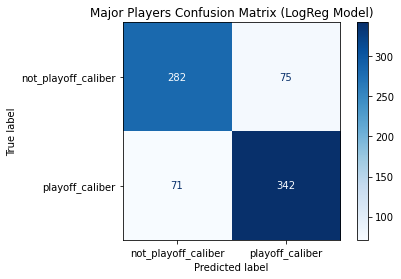

In [81]:
metrics.plot_confusion_matrix(log_gs, X_test_sc, y_test, cmap='Blues', 
                      values_format='d', display_labels=['not_playoff_caliber', 'playoff_caliber'])
plt.title('Major Players Confusion Matrix (LogReg Model)')

log_preds = log_gs.predict(X_test_sc)
tn, fp, fn, tp = metrics.confusion_matrix(y_test, log_preds).ravel()
accuracy = (tn + tp)/ (tn + fp + fn+ tp)
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
precision = tp / (tp + fp)

print('accuracy:', accuracy)
print('specificity:', specificity)
print('sensitivity:', sensitivity)
print('precision:', precision)

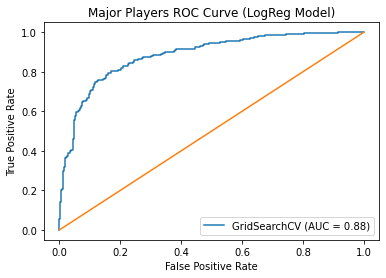

In [82]:
metrics.plot_roc_curve(log_gs, X_test_sc, y_test)
plt.plot([0, 1], [0, 1])
plt.title('Major Players ROC Curve (LogReg Model)');

**Results:** A pretty solid first pass with our LogisticRegression modeling. We can see that our test set performed at an 81% accuracy score which is roughly 28% points higher than our baseline. While we still run into some degrees of misclassification, we can see from our confusion matrix that we still capture quite a large percentage of correct classes. We also see a respectable ROC Curve showing AUC of 0.88 (closest to 1 is best) so we know there are separations in our population classes. Let's see if we can imporve at all with SVM modeling

### SVM

In [29]:
clf = svm.SVC()
gamma_range = np.logspace(-5, 2, 20)
C_range = np.logspace(-3, 2, 10)
kernel_range = ['rbf', 'sigmoid', 'linear']
param_grid = dict(gamma = gamma_range, C = C_range, kernel=kernel_range)

sv_grid = GridSearchCV(clf, param_grid, cv=5,
                   scoring = 'accuracy', n_jobs = -1,
                   verbose = 1)

sv_grid.fit(X_train_sc, y_train)
sv_grid.best_params_

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done 2452 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  2.2min finished


{'C': 27.825594022071257, 'gamma': 0.02069138081114788, 'kernel': 'rbf'}

In [30]:
print('X_train accuracy:', sv_grid.score(X_train_sc, y_train))
print('X_test accuracy:', sv_grid.score(X_test_sc, y_test))

X_train accuracy: 0.8263317453443049
X_test accuracy: 0.812987012987013


accuracy: 0.812987012987013
specificity: 0.7983193277310925
sensitivity: 0.8256658595641646
precision: 0.8256658595641646


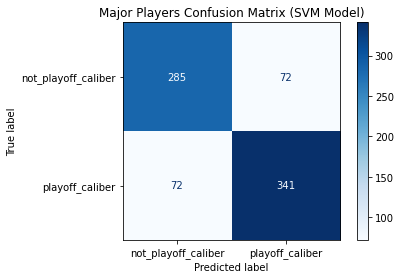

In [80]:
metrics.plot_confusion_matrix(sv_grid, X_test_sc, y_test, cmap='Blues', 
                      values_format='d', display_labels=['not_playoff_caliber', 'playoff_caliber'])
plt.title('Major Players Confusion Matrix (SVM Model)')

svm_preds = sv_grid.predict(X_test_sc)
tn, fp, fn, tp = metrics.confusion_matrix(y_test, svm_preds).ravel()
accuracy = (tn + tp)/ (tn + fp + fn+ tp)
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
precision = tp / (tp + fp)

print('accuracy:', accuracy)
print('specificity:', specificity)
print('sensitivity:', sensitivity)
print('precision:', precision)

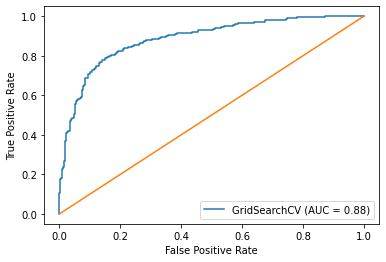

In [78]:
metrics.plot_roc_curve(sv_grid, X_test_sc, y_test)
plt.plot([0, 1], [0, 1]);

**Results:** We were able to improve upon our original model, while it may not be a monumnetal improvement, any sort of overall increase in accuracy that doesn't jeopardize the integrity of the model by overfitting is always a win. We also have a similar shaped ROC curve so should feel comfortable with using SVM model. So for our major players for 2021 we can use our SVM model to generate predictions and save that as a "is_playoff_caliber" variable.

**Major Player Predictions Using SVM Model:**

In [32]:
#scaling our 2021 data so it will align correctly with the model
major_2021_sc = ss.fit_transform(major_players_2021[features])

#creating the predictions variable for our 2021 data:
preds_major = sv_grid.predict(major_2021_sc)

#setting a column playoff caliber column:
major_players_2021['is_playoff_caliber'] = preds_major

#checking our new data
major_players_2021.head()

,name,team,year,games_played,mpg,fg%,3pfg%,rebounds,assists,steals,blocks,points_per_game,position,player_efficiency,true_shooting,plus_minus,win_shares_percentage,is_playoff_caliber
3,Bam Adebayo,MIA,2021,33,33.9,0.563,0.333,9.5,5.4,0.9,1.0,19.2,C,22.0,0.631,4.4,0.193,1
11,Giannis Antetokounmpo,MIL,2021,36,33.8,0.559,0.290,11.6,6.0,1.3,1.4,28.9,PF,29.2,0.622,8.4,0.241,1
16,OG Anunoby,TOR,2021,23,33.4,0.479,0.395,5.7,1.7,1.6,0.7,13.8,SF,13.8,0.607,0.2,0.097,0
20,Deandre Ayton,PHO,2021,36,30.8,0.595,0.235,11.2,1.6,0.3,1.1,14.4,C,18.8,0.623,-0.4,0.172,1
25,Lonzo Ball,NOP,2021,34,31.6,0.423,0.385,4.1,5.1,1.3,0.6,14.4,PG,15.0,0.557,0.7,0.080,0


## Core Players

Now let's do the same modeling format for our core players. Let's include our two successful models and run the same gridsearching to see if one model performs better than the other based on this different data set. It is possible different tiers may perform differently than others, so it's important to check at each level.

In [33]:
#First let's train test split our core players all
X_core = core_players_all[features]
y_core = core_players_all.in_playoff

X_train_core, X_test_core, y_train_core, y_test_core = train_test_split(X_core, y_core, random_state = 23, stratify = y_core) 

In [34]:
#Scale our data:
ss = StandardScaler()
X_train_sc_core = ss.fit_transform(X_train_core)
X_test_sc_core = ss.transform(X_test_core)

In [35]:
#checking our baselines:
print(y_core.value_counts(normalize=True))
print(y_train_core.value_counts(normalize=True))
print(y_test_core.value_counts(normalize=True))

0    0.550317
1    0.449683
Name: in_playoff, dtype: float64
0    0.550368
1    0.449632
Name: in_playoff, dtype: float64
0    0.550165
1    0.449835
Name: in_playoff, dtype: float64


### LogisticRegression

In [36]:
logreg_cv_core = LogisticRegressionCV()
Cs_range = np.arange(1,10)
params = {
    'Cs': Cs_range,
    'penalty' :['l1', 'l2', 'elasticnet'],
    'solver': ['lbfgs', 'liblinear', 'sag', 'saga']}
log_gs_core = GridSearchCV(logreg_cv_core, param_grid=params, cv=5,
                   scoring = 'accuracy', n_jobs = -1,
                   verbose = 1)

log_gs_core.fit(X_train_sc_core, y_train_core)
print(log_gs_core.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:    8.1s finished


{'Cs': 6, 'penalty': 'l1', 'solver': 'liblinear'}


In [37]:
print('X_train accuracy:', log_gs_core.score(X_train_sc_core, y_train_core))
print('X_test accuracy:', log_gs_core.score(X_test_sc_core, y_test_core))

X_train accuracy: 0.7849264705882353
X_test accuracy: 0.7607497243660419


accuracy: 0.7607497243660419
specificity: 0.7975951903807615
sensitivity: 0.7156862745098039
precision: 0.7430025445292621


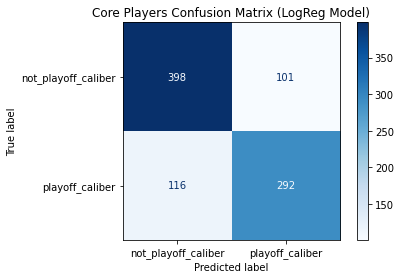

In [83]:
metrics.plot_confusion_matrix(log_gs_core, X_test_sc_core, y_test_core, cmap='Blues', 
                      values_format='d', display_labels=['not_playoff_caliber', 'playoff_caliber'])
plt.title('Core Players Confusion Matrix (LogReg Model)')

log_core_preds = log_gs_core.predict(X_test_sc_core)
tn, fp, fn, tp = metrics.confusion_matrix(y_test_core, log_core_preds).ravel()
accuracy = (tn + tp)/ (tn + fp + fn+ tp)
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
precision = tp / (tp + fp)

print('accuracy:', accuracy)
print('specificity:', specificity)
print('sensitivity:', sensitivity)
print('precision:', precision)

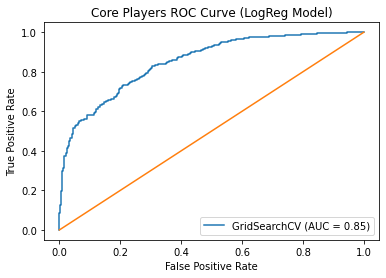

In [89]:
metrics.plot_roc_curve(log_gs_core, X_test_sc_core, y_test_core)
plt.plot([0, 1], [0, 1])
plt.title('Core Players ROC Curve (LogReg Model)');

**Results:** As we anticipated we saw a slight dropoff in performance with our models. We still observed an increase in accuracy of about 21% from our baseline, but it is understandable that our core players are harder predict since we saw through EDA the correlational relationship wasn't quite as strong with core players. This would make sense since in basketball, again albeit a team sport, it is often noted that teams will only go so far as their best players (major) will take them. ROC Curve is still within the realm of acceptable for our purposes, so we can continue to feel confident about our modeling methods. Let's run the SVM model and see if we find any accuracy improvements.

### SVM

In [39]:
clf_core = svm.SVC()
gamma_range = np.logspace(-5, 2, 20)
C_range = np.logspace(-3, 2, 10)
kernel_range = ['rbf', 'sigmoid', 'linear']
param_grid = dict(gamma = gamma_range, C = C_range, kernel=kernel_range)

sv_grid_core = GridSearchCV(clf_core, param_grid, cv=5,
                   scoring = 'accuracy', n_jobs = -1,
                   verbose = 1)

sv_grid_core.fit(X_train_sc_core, y_train_core)
sv_grid_core.best_params_

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:   52.9s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  3.4min finished


{'C': 7.742636826811277, 'gamma': 0.008858667904100823, 'kernel': 'rbf'}

In [40]:
print('X_train accuracy:', sv_grid_core.score(X_train_sc_core, y_train_core))
print('X_test accuracy:', sv_grid_core.score(X_test_sc_core, y_test_core))

X_train accuracy: 0.7889705882352941
X_test accuracy: 0.7607497243660419


accuracy: 0.7607497243660419
specificity: 0.8036072144288577
sensitivity: 0.7083333333333334
precision: 0.7467700258397932


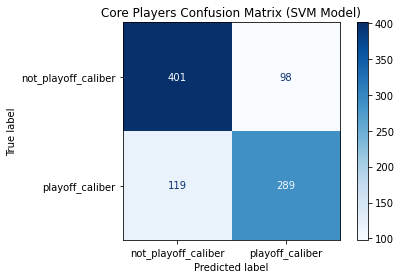

In [84]:
metrics.plot_confusion_matrix(sv_grid_core, X_test_sc_core, y_test_core, cmap='Blues', 
                      values_format='d', display_labels=['not_playoff_caliber', 'playoff_caliber'])
plt.title('Core Players Confusion Matrix (SVM Model)')

sv_core_preds = sv_grid_core.predict(X_test_sc_core)
tn, fp, fn, tp = metrics.confusion_matrix(y_test_core, sv_core_preds).ravel()
accuracy = (tn + tp)/ (tn + fp + fn+ tp)
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
precision = tp / (tp + fp)

print('accuracy:', accuracy)
print('specificity:', specificity)
print('sensitivity:', sensitivity)
print('precision:', precision)

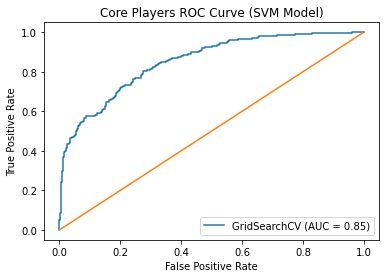

In [90]:
metrics.plot_roc_curve(sv_grid_core, X_test_sc_core, y_test_core)
plt.plot([0, 1], [0, 1])
plt.title('Core Players ROC Curve (SVM Model)');

**Results:** It looks like our testing accuracy for both models was actually identical but our training score for SVM was a bit higher. It won't make too much of a difference here which model we use but if we choose to value specificty over sensitivity it might make some differences as we can see from the confusion matrices. Since I would prefer a focus on identifying these playoff caliber players, I think the higher sensitivity score model (LogisticRegression) can work a bit better for this tier. This way we avoid missing playoff caliber playoffs and run the risk of overvaluing instead of undervaluing a player. 

**Core Player Predictions Using LogReg Model**

In [42]:
#scaling our 2021 data so it will align correctly with the model
core_2021_sc = ss.fit_transform(core_players_2021[features])

#creating the predictions variable for our 2021 data:
preds_core = log_gs_core.predict(core_2021_sc)

#setting a column playoff caliber column:
core_players_2021['is_playoff_caliber'] = preds_core

#checking our new data
core_players_2021.head()

,name,team,year,games_played,mpg,fg%,3pfg%,rebounds,assists,steals,blocks,points_per_game,position,player_efficiency,true_shooting,plus_minus,win_shares_percentage,is_playoff_caliber
2,Steven Adams,NOP,2021,34,27.8,0.614,0.000,9.0,2.0,0.9,0.6,8.2,C,16.2,0.597,-0.9,0.108,0
4,LaMarcus Aldridge,SAS,2021,21,25.9,0.464,0.360,4.5,1.7,0.4,0.9,13.7,C,15.0,0.545,-1.2,0.074,0
7,Grayson Allen,MEM,2021,23,24.0,0.409,0.407,2.8,2.2,1.0,0.1,9.3,SG,12.5,0.592,-0.2,0.110,1
8,Jarrett Allen,CLE,2021,35,27.9,0.669,0.500,9.9,1.7,0.5,1.7,13.5,C,23.6,0.714,3.4,0.219,1
10,Kyle Anderson,MEM,2021,31,27.5,0.476,0.376,6.1,3.5,1.2,0.7,13.4,PF,17.5,0.585,2.9,0.142,1


## Rotational Players

Continuing on with rotational players. Once again, this tier should be a bit more challenging than the last in terms of generating favorable accuracy scores, but let's see if we can arrive at an adequate model using the same techniques as the other tiers

In [43]:
#rotational players all
X_rot = rotational_players_all[features]
y_rot = rotational_players_all.in_playoff

X_train_rot, X_test_rot, y_train_rot, y_test_rot = train_test_split(X_rot, y_rot, random_state = 23, stratify = y_rot)

In [44]:
ss = StandardScaler()
X_train_sc_rot = ss.fit_transform(X_train_rot)
X_test_sc_rot = ss.transform(X_test_rot)

In [45]:
#checking our baselines:
print(y_rot.value_counts(normalize=True))
print(y_train_rot.value_counts(normalize=True))
print(y_test_rot.value_counts(normalize=True))

0    0.559257
1    0.440743
Name: in_playoff, dtype: float64
0    0.559382
1    0.440618
Name: in_playoff, dtype: float64
0    0.55888
1    0.44112
Name: in_playoff, dtype: float64


### LogisticRegression

In [46]:
logreg_cv_rot = LogisticRegressionCV()
Cs_range = np.arange(1,10)
params = {
    'Cs': Cs_range,
    'penalty' :['l1', 'l2', 'elasticnet'],
    'solver': ['lbfgs', 'liblinear', 'sag', 'saga']}
log_gs_rot = GridSearchCV(logreg_cv_rot, param_grid=params, cv=5,
                   scoring = 'accuracy', n_jobs = -1,
                   verbose = 1)

log_gs_rot.fit(X_train_sc_rot, y_train_rot)
print(log_gs_rot.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:    0.2s


{'Cs': 6, 'penalty': 'l1', 'solver': 'saga'}


[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:    7.9s finished


In [47]:
print('X_train accuracy:', log_gs_rot.score(X_train_sc_rot, y_train_rot))
print('X_test accuracy:', log_gs_rot.score(X_test_sc_rot, y_test_rot))

X_train accuracy: 0.7409076279369167
X_test accuracy: 0.7200772200772201


accuracy: 0.7200772200772201
specificity: 0.7616580310880829
sensitivity: 0.6673960612691466
precision: 0.6884875846501128


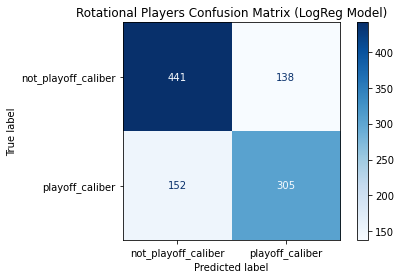

In [85]:
metrics.plot_confusion_matrix(log_gs_rot, X_test_sc_rot, y_test_rot, cmap='Blues', 
                      values_format='d', display_labels=['not_playoff_caliber', 'playoff_caliber'])
plt.title('Rotational Players Confusion Matrix (LogReg Model)')

log_rot_preds = log_gs_rot.predict(X_test_sc_rot)
tn, fp, fn, tp = metrics.confusion_matrix(y_test_rot, log_rot_preds).ravel()
accuracy = (tn + tp)/ (tn + fp + fn+ tp)
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
precision = tp / (tp + fp)

print('accuracy:', accuracy)
print('specificity:', specificity)
print('sensitivity:', sensitivity)
print('precision:', precision)

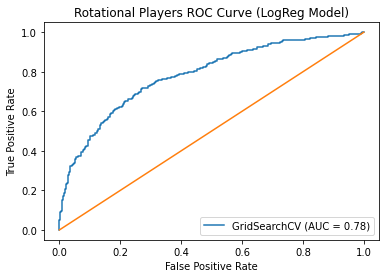

In [91]:
metrics.plot_roc_curve(log_gs_rot, X_test_sc_rot, y_test_rot)
plt.plot([0, 1], [0, 1])
plt.title('Rotational Players ROC Curve (LogReg Model)');

**Findings:** A slight decrease again, but still able to to beat our baseline by roughly 17%. Considering how hard it is to account for a playoff caliber rotational player, I would say that this is a favorable score. This difficulty in predicting as we move down player tiers is shown with our ROC Curve starting to bend towads our 0.5 line, but again our score is still on the more ideal spectrum of ROC curve results. Let's try out SVM model and see if we can improve

### SVM

In [49]:
clf_rot = svm.SVC()
gamma_range = np.logspace(-5, 2, 20)
C_range = np.logspace(-3, 2, 10)
kernel_range = ['rbf', 'sigmoid', 'linear']
param_grid = dict(gamma = gamma_range, C = C_range, kernel=kernel_range)

sv_grid_rot = GridSearchCV(clf_rot, param_grid, cv=5,
                   scoring = 'accuracy', n_jobs = -1,
                   verbose = 1)

sv_grid_rot.fit(X_train_sc_rot, y_train_rot)
sv_grid_rot.best_params_

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   53.8s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  5.2min finished


{'C': 100.0, 'gamma': 0.00379269019073225, 'kernel': 'rbf'}

In [50]:
print('X_train accuracy:', sv_grid_rot.score(X_train_sc_rot, y_train_rot))
print('X_test accuracy:', sv_grid_rot.score(X_test_sc_rot, y_test_rot))

X_train accuracy: 0.753781783070486
X_test accuracy: 0.7104247104247104


accuracy: 0.7104247104247104
specificity: 0.7633851468048359
sensitivity: 0.6433260393873085
precision: 0.6821345707656613


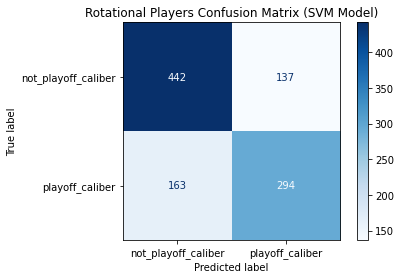

In [86]:
metrics.plot_confusion_matrix(sv_grid_rot, X_test_sc_rot, y_test_rot, cmap='Blues', 
                      values_format='d', display_labels=['not_playoff_caliber', 'playoff_caliber'])
plt.title('Rotational Players Confusion Matrix (SVM Model)')

sv_rot_preds = sv_grid_rot.predict(X_test_sc_rot)
tn, fp, fn, tp = metrics.confusion_matrix(y_test_rot, sv_rot_preds).ravel()
accuracy = (tn + tp)/ (tn + fp + fn+ tp)
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
precision = tp / (tp + fp)

print('accuracy:', accuracy)
print('specificity:', specificity)
print('sensitivity:', sensitivity)
print('precision:', precision)

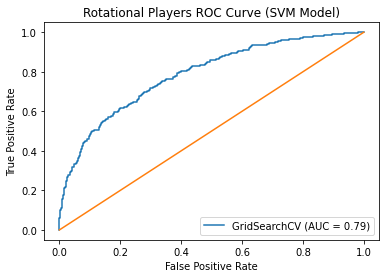

In [92]:
metrics.plot_roc_curve(sv_grid_rot, X_test_sc_rot, y_test_rot)
plt.plot([0, 1], [0, 1])
plt.title('Rotational Players ROC Curve (SVM Model)');

**Results:** Here we see a slight deviation in score with a better testing score with LogisticRegression and higher training with SVM. Again, both acceptable model choices, but let's select the one with less overfitting and a higher testing score and use our LogReg for the rotational player predictions, although as we see from our ROC Curve if we could still within reason use our SVM model despite the overfitting (if we wanted to).

**Rotational Player Predictions Using LogReg Model**

In [52]:
#scaling our 2021 data so it will align correctly with the model
rot_2021_sc = ss.fit_transform(rotational_players_2021[features])

#creating the predictions variable for our 2021 data:
preds_rot = log_gs_rot.predict(rot_2021_sc)

#setting a column playoff caliber column:
rotational_players_2021['is_playoff_caliber'] = preds_rot

#checking our new data
rotational_players_2021.head()

,name,team,year,games_played,mpg,fg%,3pfg%,rebounds,assists,steals,blocks,points_per_game,position,player_efficiency,true_shooting,plus_minus,win_shares_percentage,is_playoff_caliber
0,Precious Achiuwa,MIA,2021,36,13.8,0.582,0.000,4.0,0.6,0.4,0.5,5.9,PF,15.4,0.586,-2.8,0.108,0
6,Nickeil Alexander-Walker,NOP,2021,29,17.9,0.407,0.307,2.4,1.9,1.0,0.3,8.3,SG,12.1,0.507,-2.1,0.024,0
17,Ryan Arcidiacono,CHI,2021,19,10.8,0.404,0.333,1.8,1.2,0.3,0.0,3.2,PG,10.1,0.545,-2.5,0.088,1
18,D.J. Augustin,MIL,2021,35,19.5,0.364,0.381,1.4,3.0,0.6,0.0,6.3,PG,10.5,0.538,-1.9,0.084,1
34,Kent Bazemore,GSW,2021,36,16.8,0.472,0.424,2.9,1.6,0.9,0.5,6.5,SF,12.4,0.600,0.1,0.092,0


## Reserve Players 

Last, but not least, our reserve players. As we saw with our EDA this should be a challenge, but the fact that it may be so close to the baseline using the same already successful features with the other tiers, may provide enough insight that if we cannot improve to a satisfactory level, reserve players may not be overly critical to a winning team (**Note: Important from an in-game performance standpoint. Reserve players can add immeasurable value to a winning team in other ways outside of the games themselves**)

In [53]:
#reserves players all
X_res = reserve_players_all[features]
y_res = reserve_players_all.in_playoff

X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_res, y_res, random_state = 23, stratify = y_res)

In [54]:
ss = StandardScaler()
X_train_sc_res = ss.fit_transform(X_train_res)
X_test_sc_res = ss.transform(X_test_res)

In [55]:
#checking our baselines:
print(y_res.value_counts(normalize=True))
print(y_train_res.value_counts(normalize=True))
print(y_test_res.value_counts(normalize=True))

1    0.557648
0    0.442352
Name: in_playoff, dtype: float64
1    0.557663
0    0.442337
Name: in_playoff, dtype: float64
1    0.557604
0    0.442396
Name: in_playoff, dtype: float64


### LogisticRegression

In [56]:
logreg_cv_res = LogisticRegressionCV()
Cs_range = np.arange(1,10)
params = {
    'Cs': Cs_range,
    'penalty' :['l1', 'l2', 'elasticnet'],
    'solver': ['lbfgs', 'liblinear', 'sag', 'saga']}
log_gs_res = GridSearchCV(logreg_cv_res, param_grid=params, cv=5,
                   scoring = 'accuracy', n_jobs = -1,
                   verbose = 1)

log_gs_res.fit(X_train_sc_res, y_train_res)
print(log_gs_res.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:    7.5s finished


{'Cs': 6, 'penalty': 'l1', 'solver': 'saga'}


In [57]:
print('X_train accuracy:', log_gs_res.score(X_train_sc_res, y_train_res))
print('X_test accuracy:', log_gs_res.score(X_test_sc_res, y_test_res))

X_train accuracy: 0.5786776012301383
X_test accuracy: 0.565284178187404


accuracy: 0.565284178187404
specificity: 0.19791666666666666
sensitivity: 0.8567493112947658
precision: 0.5738007380073801


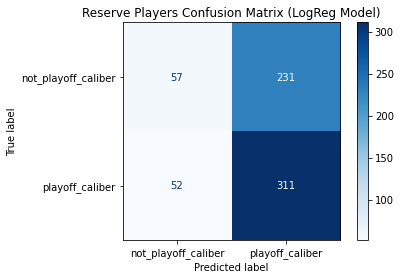

In [87]:
metrics.plot_confusion_matrix(log_gs_res, X_test_sc_res, y_test_res, cmap='Blues', 
                      values_format='d', display_labels=['not_playoff_caliber', 'playoff_caliber'])
plt.title('Reserve Players Confusion Matrix (LogReg Model)')

log_res_preds = log_gs_res.predict(X_test_sc_res)
tn, fp, fn, tp = metrics.confusion_matrix(y_test_res, log_res_preds).ravel()
accuracy = (tn + tp)/ (tn + fp + fn+ tp)
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
precision = tp / (tp + fp)

print('accuracy:', accuracy)
print('specificity:', specificity)
print('sensitivity:', sensitivity)
print('precision:', precision)

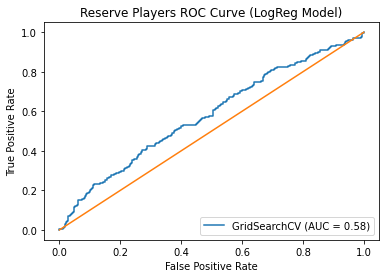

In [93]:
metrics.plot_roc_curve(log_gs_res, X_test_sc_res, y_test_res)
plt.plot([0, 1], [0, 1])
plt.title('Reserve Players ROC Curve (LogReg Model)');

**Results:** Yikes! Not a great improvement from the baseline by any means with some very lopsided specificity vs sensitivity scores. It looks like our model is essentially just labeling all reserves as playoff caliber, which a silverish lining means that at least we aren't missing out on potential playoff caliber reserves by overvaluing all the players. But again, we obviously run the risk in this scenario of designating some playoff caliber when in fact they are not. (False Positives) Let's now try our SVM model and see if we have any better luck

### SVM

In [59]:
clf_res = svm.SVC()
gamma_range = np.logspace(-5, 2, 20)
C_range = np.logspace(-3, 2, 10)
kernel_range = ['rbf', 'sigmoid']
param_grid = dict(gamma = gamma_range, C = C_range, kernel=kernel_range)

sv_grid_res = GridSearchCV(clf_res, param_grid, cv=3,
                   scoring = 'accuracy', n_jobs = -1,
                   verbose = 1)

sv_grid_res.fit(X_train_sc_res, y_train_res)
sv_grid_res.best_params_

Fitting 3 folds for each of 400 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:   21.6s finished


{'C': 27.825594022071257, 'gamma': 0.04832930238571752, 'kernel': 'rbf'}

In [60]:
print('X_train accuracy:', sv_grid_res.score(X_train_sc_res, y_train_res))
print('X_test accuracy:', sv_grid_res.score(X_test_sc_res, y_test_res))

X_train accuracy: 0.7406458226550487
X_test accuracy: 0.6374807987711214


accuracy: 0.6374807987711214
specificity: 0.5
sensitivity: 0.7465564738292011
precision: 0.653012048192771


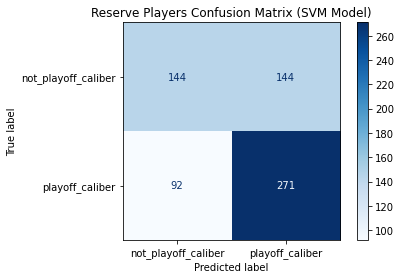

In [88]:
metrics.plot_confusion_matrix(sv_grid_res, X_test_sc_res, y_test_res, cmap='Blues', 
                      values_format='d', display_labels=['not_playoff_caliber', 'playoff_caliber'])
plt.title('Reserve Players Confusion Matrix (SVM Model)')

sv_res_preds = sv_grid_res.predict(X_test_sc_res)
tn, fp, fn, tp = metrics.confusion_matrix(y_test_res, sv_res_preds).ravel()
accuracy = (tn + tp)/ (tn + fp + fn+ tp)
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
precision = tp / (tp + fp)

print('accuracy:', accuracy)
print('specificity:', specificity)
print('sensitivity:', sensitivity)
print('precision:', precision)

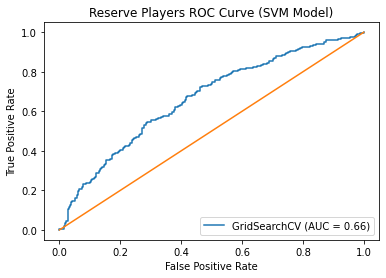

In [96]:
metrics.plot_roc_curve(sv_grid_res, X_test_sc_res, y_test_res)
plt.plot([0, 1], [0, 1])
plt.title('Reserve Players ROC Curve (SVM Model)');

**Results:** Again not the prettiest of scores, but despite being overfit by a significant amount, our testing score was much better comparatively with SVM in this case. Our sensitivity score may not be as high, but the other metrics are a lot less lopsided than the logreg model. I would say that all things consider it would be best to use the SVM model in this case despite the overfitting. We will miss out on some playoff caliber players from a classification rate, but we will also do a better job at identifying non-playoff caliber talent. We can also see our ROC Curve is much more favorable with the SVM Model, so we should be partial towards our SVM decision for this tier.

**Reserve Player Predictions Using SVM Model**

In [62]:
#scaling our 2021 data so it will align correctly with the model
res_2021_sc = ss.fit_transform(reserve_players_2021[features])

#creating the predictions variable for our 2021 data:
preds_res = sv_grid_res.predict(res_2021_sc)

#setting a column playoff caliber column:
reserve_players_2021['is_playoff_caliber'] = preds_res

#checking our new data
reserve_players_2021.head()

,name,team,year,games_played,mpg,fg%,3pfg%,rebounds,assists,steals,blocks,points_per_game,position,player_efficiency,true_shooting,plus_minus,win_shares_percentage,is_playoff_caliber
1,Jaylen Adams,MIL,2021,7,2.6,0.125,0.000,0.4,0.3,0.0,0.0,0.3,PG,-6.6,0.125,-19.8,-0.250,1
5,Ty-Shon Alexander,PHO,2021,3,2.7,0.000,0.000,0.3,0.3,0.0,0.0,0.0,SG,-11.9,0.000,-21.2,-0.323,1
12,Kostas Antetokounmpo,LAL,2021,3,6.3,0.333,0.000,2.7,0.0,0.3,0.7,1.0,PF,-0.2,0.387,-12.3,-0.202,0
13,Thanasis Antetokounmpo,MIL,2021,27,8.9,0.609,0.222,2.1,0.7,0.3,0.2,2.4,SF,11.3,0.619,-2.8,0.090,1
21,Udoka Azubuike,UTA,2021,12,4.1,0.571,0.000,1.1,0.0,0.1,0.3,1.0,C,10.6,0.622,-4.3,0.107,1


### Merging Predictions

Now that we have all the players evaluated with our model, let's concatenate them all together. This way we will be able to analyze on a per team basis and build our team recommendation based on the predictions generated by our model for each tier 

In [63]:
df=pd.concat([major_players_2021, core_players_2021, rotational_players_2021, reserve_players_2021])
#saving as a csv as well:
# `df.to_csv('data/2021_players_predictions.csv')
df.head()

,name,team,year,games_played,mpg,fg%,3pfg%,rebounds,assists,steals,blocks,points_per_game,position,player_efficiency,true_shooting,plus_minus,win_shares_percentage,is_playoff_caliber
3,Bam Adebayo,MIA,2021,33,33.9,0.563,0.333,9.5,5.4,0.9,1.0,19.2,C,22.0,0.631,4.4,0.193,1
11,Giannis Antetokounmpo,MIL,2021,36,33.8,0.559,0.290,11.6,6.0,1.3,1.4,28.9,PF,29.2,0.622,8.4,0.241,1
16,OG Anunoby,TOR,2021,23,33.4,0.479,0.395,5.7,1.7,1.6,0.7,13.8,SF,13.8,0.607,0.2,0.097,0
20,Deandre Ayton,PHO,2021,36,30.8,0.595,0.235,11.2,1.6,0.3,1.1,14.4,C,18.8,0.623,-0.4,0.172,1
25,Lonzo Ball,NOP,2021,34,31.6,0.423,0.385,4.1,5.1,1.3,0.6,14.4,PG,15.0,0.557,0.7,0.080,0


## Analysis

First, before examining our team in question, the Boston Celtics, let's take a look at some examples to make sure that our model was effective with it's predictions. Assuming our methods make sense we should see most of the first place teams with high presence of "playoff caliber" players while teams with less favorable records at the moment should have comparatively much less. Let's take a look at the Western Conference, at this moment in time the Utah Jazz are atop the standings with a record of 27-9 while the Minnesota Timberwolves are a measly 8-29. Let's use these two extremes to test our theory:

In [64]:
print(df[df['team'] == 'UTA'].is_playoff_caliber.value_counts())
df[df['team'] == 'UTA']

1    14
0     2
Name: is_playoff_caliber, dtype: int64


,name,team,year,games_played,mpg,fg%,3pfg%,rebounds,assists,steals,blocks,points_per_game,position,player_efficiency,true_shooting,plus_minus,win_shares_percentage,is_playoff_caliber
51,Bojan Bogdanović,UTA,2021,36,30.6,0.432,0.405,3.9,1.9,0.5,0.1,15.7,SF,13.3,0.587,-0.7,0.114,1
162,Rudy Gobert,UTA,2021,36,30.7,0.641,0.000,13.1,1.3,0.5,2.7,14.2,C,22.5,0.649,3.4,0.220,0
316,Donovan Mitchell,UTA,2021,34,33.9,0.421,0.382,4.7,5.4,1.0,0.3,24.7,SG,18.9,0.549,1.7,0.134,1
343,Royce O'Neale,UTA,2021,36,32.8,0.441,0.411,6.8,2.6,0.8,0.6,7.6,SF,10.0,0.606,0.4,0.120,1
94,Jordan Clarkson,UTA,2021,36,26.0,0.447,0.370,4.0,2.3,0.9,0.2,17.9,SG,18.7,0.581,2.7,0.137,1
98,Mike Conley,UTA,2021,29,29.4,0.444,0.422,3.5,5.7,1.4,0.1,16.1,PG,19.2,0.588,3.9,0.194,1
219,Joe Ingles,UTA,2021,32,26.4,0.522,0.465,3.3,4.4,0.5,0.3,11.5,SF,16.5,0.705,3.9,0.190,1
137,Derrick Favors,UTA,2021,34,16.2,0.649,0.000,5.5,0.8,0.5,0.9,6.3,C,20.2,0.689,2.3,0.244,1
334,Georges Niang,UTA,2021,36,13.4,0.431,0.385,2.2,0.7,0.3,0.1,5.4,PF,9.9,0.573,-1.9,0.081,1
21,Udoka Azubuike,UTA,2021,12,4.1,0.571,0.000,1.1,0.0,0.1,0.3,1.0,C,10.6,0.622,-4.3,0.107,1


14 Playoff caliber players with only 2 non-playoff caliber players. Pretty solid team build I would say. Now let's check in on the TWolves 

In [65]:
print(df[df['team'] == 'MIN'].is_playoff_caliber.value_counts())
df[df['team'] == 'MIN']

0    14
1     2
Name: is_playoff_caliber, dtype: int64


,name,team,year,games_played,mpg,fg%,3pfg%,rebounds,assists,steals,blocks,points_per_game,position,player_efficiency,true_shooting,plus_minus,win_shares_percentage,is_playoff_caliber
37,Malik Beasley,MIN,2021,33,33.1,0.455,0.406,4.6,2.5,0.8,0.2,20.5,SG,15.9,0.582,0.3,0.073,0
446,Karl-Anthony Towns,MIN,2021,17,32.5,0.485,0.356,10.7,3.8,0.8,1.7,21.6,C,21.8,0.598,3.2,0.128,0
128,Anthony Edwards,MIN,2021,37,29.3,0.374,0.304,4.0,2.5,0.9,0.4,15.2,SG,10.0,0.469,-5.1,-0.038,0
389,Naz Reid,MIN,2021,35,20.7,0.522,0.340,4.7,1.3,0.7,1.2,11.9,C,18.4,0.599,0.1,0.118,0
403,Ricky Rubio,MIN,2021,35,25.4,0.384,0.321,3.1,6.5,1.3,0.0,7.9,PG,12.0,0.503,-3.5,0.054,0
404,D'Angelo Russell,MIN,2021,20,29.2,0.426,0.399,2.6,5.1,1.1,0.5,19.3,PG,16.2,0.544,0.4,0.037,0
106,Jarrett Culver,MIN,2021,19,19.8,0.422,0.229,4.7,0.8,0.6,0.4,7.2,SG,9.3,0.478,-6.7,-0.004,0
110,Ed Davis,MIN,2021,19,13.9,0.419,0.000,5.1,1.0,0.5,0.5,2.3,C,12.1,0.462,-3.4,0.117,1
196,Juan Hernangómez,MIN,2021,18,15.4,0.409,0.315,4.2,0.6,0.3,0.1,5.9,PF,11.6,0.523,-3.4,0.058,0
259,Jake Layman,MIN,2021,25,15.8,0.516,0.346,1.6,0.6,0.8,0.5,6.6,SF,13.3,0.618,-1.2,0.080,0


Yikes, not so great! But the findings would support the effectiveness of our model. The last place timbervolves, this year, only have 1 player who would qualify as playoff caliber. This is no surprise as their best player, franchise cornerstone, Karl Anthony Towns has played under half the season. Without your best player, a team is more often than not going to struggle. 

## Recommendations

Since we were approached specifically by the Boston Celtics, let's take a look at their team tier by tier and see how their players measure up from a "playoff caliber" classification established by our models. The Celtics have experience a bit of a rocky season to this point, and currently sit 4th in the playoff rankings for the Eastern Conference at a 19-18 record. Let's take a look at how their major players have performed thus far:

In [66]:
print(major_players_2021[major_players_2021['team'] == 'BOS'].is_playoff_caliber.value_counts())
major_players_2021[major_players_2021['team'] == 'BOS']

0    3
1    1
Name: is_playoff_caliber, dtype: int64


,name,team,year,games_played,mpg,fg%,3pfg%,rebounds,assists,steals,blocks,points_per_game,position,player_efficiency,true_shooting,plus_minus,win_shares_percentage,is_playoff_caliber
68,Jaylen Brown,BOS,2021,34,34.0,0.485,0.380,5.6,4.0,1.2,0.5,24.4,SG,20.3,0.581,2.8,0.118,0
420,Marcus Smart,BOS,2021,18,31.7,0.402,0.326,2.7,5.8,1.7,0.6,13.4,PG,15.5,0.535,0.9,0.117,1
432,Jayson Tatum,BOS,2021,32,35.8,0.442,0.370,7.0,4.4,1.3,0.5,25.1,SF,19.9,0.551,3.1,0.112,0
460,Kemba Walker,BOS,2021,21,30.2,0.389,0.357,3.6,4.4,1.0,0.4,18.1,PG,16.0,0.528,0.8,0.072,0


**Analysis:** On the surface, not a very good result. Of the Celtics Power Four players, only one, Marcus Smart, is viewed as a playoff caliber player at the halfway mark. For any avid Celtics fan, this may not come as the biggest surprise as the Celtics have experienced a myriad of woes in the early goings ranging from untimely injuries to just disappointing close losses. While all four of these players have had terrific seasons in the past and certainly possess a lot of potential it is no secret that the Celtics season to date has been a disappointing one. Fairly recently their GM and Director of Operations, Danny Ainge, had this to say about his ballclub:

https://985thesportshub.com/2021/02/18/danny-ainge-says-celtics-do-not-have-a-championship-roster/

As we've highlighted throughout the report, these less than desirable records and their blame typically fall at the feet of your stars (major players). 

**Recommendations:** This may go against the intuition of my own model, but I don't suggest seeking a trade or a change from any of these current players. While they may have underperformed over the course of the first half of the season, I believe there are enough underlying factors to contradict what the model is suggesting. In the case of Kemba Walker, he is coming off knee surgery so has been struggling to find his rhythm, but his play has been trending upwards lately and is returning to his former playoff caliber self. But again, it's not surprise to see that the Celtics GM reportedly was shopping Kemba around this season:

https://www.masslive.com/celtics/2021/02/kemba-walker-trade-rumors-celtics-tried-like-hell-to-trade-guard-danny-ainge-knew-knee-wasnt-right-report.html

https://www.espn.com/nba/story/_/id/30984749/why-jayson-tatum-jaylen-brown-enough-boston-celtics-season

Jayson Tatum and Jaylen Brown both nothced their 2nd and 1st All Star appearances (respectively) so despite a lackluster 1st half, possess enough potential and talent to turn it around. These two are newly annointed franchise players at the absurdly young age of 23 & 24 years old and along with their recently inked large contracts would be reason enough to continue to give them a chance. It may not be this season, but hopefully the scouting pays off and they establish themselves well past "playoff caliber."

https://www.celticsblog.com/2021/3/11/22321297/the-evolution-of-jayson-tatums-shot-making-ability-boston-celtics-nba


In [67]:
print(core_players_2021[core_players_2021['team'] == 'BOS'].is_playoff_caliber.value_counts())
core_players_2021[core_players_2021['team'] == 'BOS']

0    2
1    1
Name: is_playoff_caliber, dtype: int64


,name,team,year,games_played,mpg,fg%,3pfg%,rebounds,assists,steals,blocks,points_per_game,position,player_efficiency,true_shooting,plus_minus,win_shares_percentage,is_playoff_caliber
381,Payton Pritchard,BOS,2021,31,21.1,0.451,0.400,2.3,2.3,0.6,0.2,7.5,SG,11.1,0.580,-2.1,0.074,0
436,Daniel Theis,BOS,2021,35,24.4,0.570,0.368,5.1,1.3,0.7,1.1,9.5,C,15.5,0.645,0.3,0.137,1
439,Tristan Thompson,BOS,2021,35,22.7,0.535,0.000,8.3,1.0,0.3,0.4,7.9,PF,15.5,0.556,-2.2,0.120,0


**Analysis:** Again, not what you would want to see from you main core players. While it is nice to see Daniel Theis earning his playoff caliber stripes, who has been playing quite well of late, you would like to see more production of players like Tristan Thompson. Albeit he may impact the game from a non-box score standpoint, does pose as an interesting potential to trade and provide upgrades to the PF position. 

**Recommendation:** Payton Pritchard, a rookie, has been a bright spot for the Celtics this year provided often needed hustle and timely shooting. While he doesn't notch a playoff caliber classification, he is shooting a healthy 40% from beyond the arc, which if we recall from our clustering via EDA, 3 point shooting has become a major focal point of the modern game. His shooting paired with simply being a rookie, I recommend keeping him but would certainly field any offers from teams if the Celtics are looking to make a much needed upgrade to their core group. 

Theis, the only playoff caliber of the bunch might make the most sense if the Celtics are looking to make a trade. Theis is a Center who can stretch the floor and shoot a high percentage from beyond the arc, the only question is his trade value. For a team looking to inject some shooting paired with size, Daniel and the Celtics could make a great trading partner.

In [68]:
print(rotational_players_2021[rotational_players_2021['team'] == 'BOS'].is_playoff_caliber.value_counts())
rotational_players_2021[rotational_players_2021['team'] == 'BOS']

0    4
1    3
Name: is_playoff_caliber, dtype: int64


,name,team,year,games_played,mpg,fg%,3pfg%,rebounds,assists,steals,blocks,points_per_game,position,player_efficiency,true_shooting,plus_minus,win_shares_percentage,is_playoff_caliber
129,Carsen Edwards,BOS,2021,14,10.5,0.460,0.324,1.0,0.4,0.3,0.1,5.4,SG,13.6,0.568,-3.4,0.101,1
171,Javonte Green,BOS,2021,22,15.0,0.549,0.318,2.3,0.5,0.8,0.1,4.8,SG,12.7,0.624,-0.4,0.109,0
332,Aaron Nesmith,BOS,2021,18,15.6,0.397,0.354,2.4,0.4,0.2,0.3,4.2,SF,6.2,0.549,-4.7,0.033,0
344,Semi Ojeleye,BOS,2021,34,19.0,0.417,0.383,2.9,0.8,0.3,0.0,5.5,PF,9.0,0.572,-2.1,0.072,1
433,Jeff Teague,BOS,2021,29,18.0,0.377,0.435,1.6,2.1,0.8,0.2,6.4,PG,10.2,0.509,-3.3,0.037,0
476,Grant Williams,BOS,2021,29,18.4,0.462,0.419,3.0,0.9,0.5,0.4,5.1,PF,8.3,0.574,-3.8,0.053,0
480,Robert Williams,BOS,2021,30,16.1,0.706,0.000,5.8,1.2,0.9,1.6,6.8,C,25.7,0.709,5.6,0.244,1


**Analysis:** Continuing the disappointing trend, the Celtics rotational players trend in a non playoff caliber direction. But a bright to spot to note is that as I have rerun my model from earlier this week until now (with updated stats), Robert Williams went from non playoff caliber to playoff caliber. This would make sense for anybody who has been watching him recently and can see how much of an impact he has been making to the roster. He's playing efficiently and at a higher clip after earning Coach Steven's trust.

**Recommendation:** Improvements can clearly be made in the depth department, so I would suggest exploring trades for any of these players with the exception of Robert Williams (despite being non caliber through my model). Again just another highlight of how it's important to leverage the model instead of solely relying on it to make our decisions. 

In [69]:
print(reserve_players_2021[reserve_players_2021['team'] == 'BOS'].is_playoff_caliber.value_counts())
reserve_players_2021[reserve_players_2021['team'] == 'BOS']

1    2
Name: is_playoff_caliber, dtype: int64


,name,team,year,games_played,mpg,fg%,3pfg%,rebounds,assists,steals,blocks,points_per_game,position,player_efficiency,true_shooting,plus_minus,win_shares_percentage,is_playoff_caliber
136,Tacko Fall,BOS,2021,8,7.1,0.692,0.0,2.6,0.1,0.0,1.3,2.6,C,22.4,0.636,2.4,0.218,1
467,Tremont Waters,BOS,2021,10,9.8,0.323,0.4,0.8,3.0,0.6,0.0,3.3,PG,11.7,0.478,-1.3,0.019,1


**Analysis:** It's nice to see fan favorite Tacko Fall make his way as a playoff caliber reserve player. Tacko doesn't play all to often, but at his size 7'5" he is always a treat to play. It also seems that when he does get an opportunity he is rather efficient, generating a 22.4 player efficiency score. Although, he is usually playing against fellow reserves, so be mindful to not get overly excited.

**Recommendations:** Keep these two players, Tacko Fall is a fan icon! 

### Next Steps Closing Remarks

I would like to perform the same style of modeling but take it a step further, either by modeling based on the most recent decade to see if my accuracy can improve at all, and as well take a look at modeling further by position. I think that with more cuts and contextualizing (so comparing star Shooting Guards to other star Shooting Guards) we will be able to get better results and really highlight a player's performance in respect to the other players in his tier across the league. 

As we've noted throughout the project, basketball is still a team game. So while the model does a solid job at measuring individual impact and contributions made towards winning, those contributions can be held back if the elite player is surrounded by sub par players. So it is important to note that the model is imperfect and that NBA talent scouts should consider their jobs relatively safe. As we've detailed through my analysis, use this model as a tool to evaluate how players have performed thus far, but pair that with domain knowledge in order to make appropriate recommendations. 

For the Celtics, while they have potential to make moves to better their team, I don't think it is likely. As shown in the article above, the GM doesn't think they are poised to make a deep run in playoffs and considering my model shows that the majority of their playoffs aren't deemed playoff caliber, I agree. So while I recommend exploring trade options, I think the best plan of attack would be to finish the season out and hope for a turnaround in performance by their main 3 stars Tatum, Brown, and Walker. Looks like GM Danny Ainge agrees:

https://nesn.com/2021/03/boston-celtics-trade-rumors-danny-ainge-tpe/